# Unser Finanzprojekt

Dieses Notebook enthält Datenbereinigung und Analysen zur Zeitreihe der Preisentwicklung des Deutschen Aktienindex DAX.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read in csv data
df = pd.read_csv("GDAX_histdata.csv",)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8722,2021-11-10,16053.000000,16076.559570,15985.900391,16067.830078,16067.830078,62124400.0
8723,2021-11-11,16067.339844,16114.549805,16032.500000,16083.110352,16083.110352,56626200.0
8724,2021-11-12,16100.080078,16122.759766,16065.059570,16094.070313,16094.070313,60302900.0
8725,2021-11-15,16109.410156,16149.870117,16072.290039,16148.639648,16148.639648,53296600.0
8726,2021-11-16,16174.309570,16266.259766,16157.580078,16247.860352,16247.860352,56783300.0


In [3]:
#general statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,8559.0,6.053019e+03,3.801706e+03,936.0,2540.349976,5.471700e+03,8.141850e+03,1.617431e+04
High,8559.0,6.094780e+03,3.823382e+03,936.0,2549.760010,5.523670e+03,8.193645e+03,1.626626e+04
Low,8559.0,6.006814e+03,3.777956e+03,936.0,2524.994996,5.419550e+03,8.097360e+03,1.615758e+04
Close,8559.0,6.052400e+03,3.801565e+03,936.0,2540.334961,5.468470e+03,8.125125e+03,1.624786e+04
Adj Close,8559.0,6.052400e+03,3.801565e+03,936.0,2540.334961,5.468470e+03,8.125125e+03,1.624786e+04
Volume,8559.0,6.814296e+07,6.434472e+07,0.0,0.000000,7.229720e+07,1.064260e+08,5.101956e+08


In [4]:
#check for holidays
df.loc[df["Close"].isna(),"Date"]

1       1987-12-31
2       1988-01-01
67      1988-04-01
68      1988-04-04
96      1988-05-12
           ...    
7232    2015-12-25
7598    2017-06-05
7684    2017-10-03
7704    2017-10-31
7842    2018-05-21
Name: Date, Length: 168, dtype: object

In [5]:
#drop rows for holidays, then reset index (continuous trading days)
df = df.dropna()
df["Day_count"] = np.arange(0,df.shape[0])
df.set_index("Day_count",inplace=True)


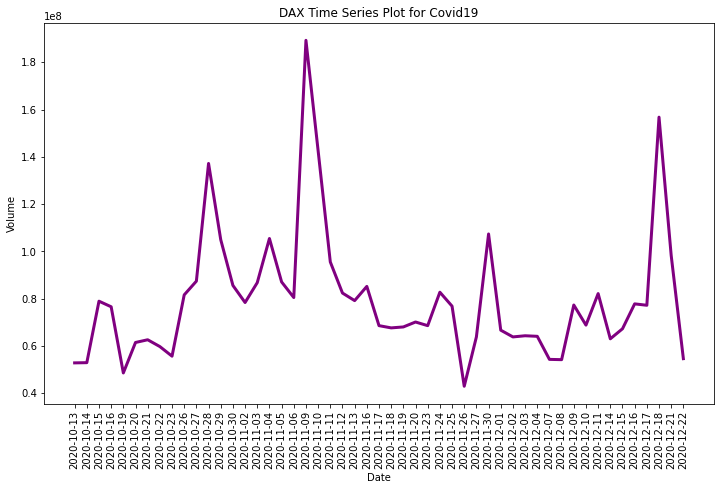

In [6]:
fig,ax = plt.subplots(figsize=[12,7])
sns.lineplot(x=df.loc[8280:8330,"Date"],
             y=df.loc[8280:8330,"Volume"],
             linewidth=3, color='purple',
             ).set(title='DAX Time Series Plot for Covid19');
plt.xticks(rotation=90);

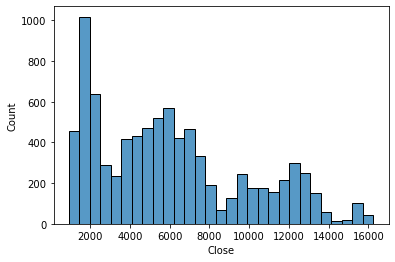

In [7]:
sns.histplot(df["Close"]);

In [8]:
#df=df.loc[:300,:]


def calculate_ema(prices, days, smoothing=2):
    """
    Calculate EMA for given stock prices (list or df column) 
    and given number of days (int), usually 10,20,38,50,100 or 200
    Calculates SMA for first number of days of averaging
    Returns EMA for given period
    """
    
    #Initialize EMA with stock price of first day
    ema = [prices[0]]
    #print(0,ema)
    
    #Calculate SMA for first X days with X being days
    for day in range(1,days):
        ema.append(sum(prices[:day]) / day)
        #print(day,ema[day])
    
    #Start appending EMA values at day'th value
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
        
    return ema

        #symbol = 'MSFT'
        #df = web.DataReader(symbol, 'yahoo', '2015-01-01', '2016-01-01')



In [9]:
#Ziel:
# Herausfinden, wie gut EMA Schnittpunkt dient, größere Rallyes vorherzusagen (Einstiegszeitpunkt)
#     + Grafik dazu für Fälle in denen EMA38 den EMA200 von unten nach oben schneidet:
#             x: Tage nach Ereignis
#             y: prozentuale Veränderung des Preises

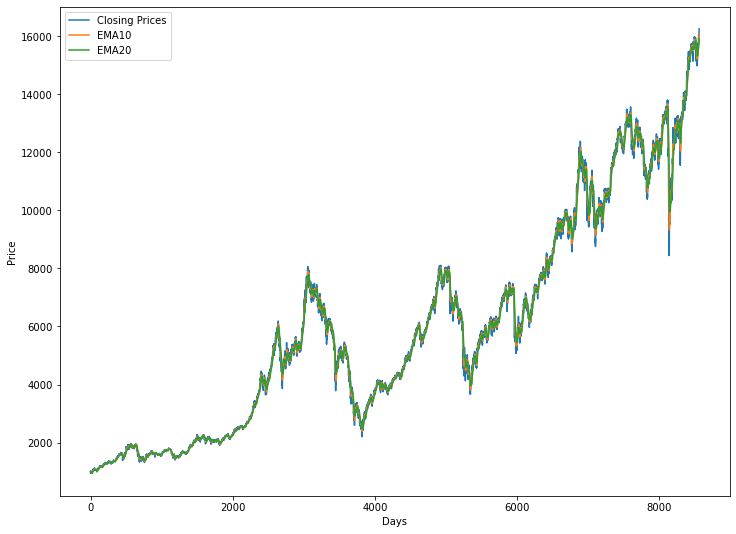

In [40]:
days=10
ema = calculate_ema(prices=df['Close'], days=days)
days2=20
ema2 = calculate_ema(prices=df['Close'], days=days2)

price_X = np.arange(df.shape[0])     
ema_X = np.arange(1, df.shape[0]+1) 
ema_X2 = np.arange(1, df.shape[0]+1)


plt.subplots(figsize=[12,9])
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(price_X, df['Close'], label='Closing Prices')
plt.plot(ema_X, ema, label='EMA'+str(days))
plt.plot(ema_X2, ema2, label='EMA'+str(days2))
plt.legend()
plt.show()

In [43]:
##### Retrieve day at which upward crossing occurs
ndays,ndays2 = 5,10
col_gains=[]
print("Day |  Date  |  Percental change after    ",ndays," / ",ndays2,"      trading days")
for i in range(1,len(ema)):
    w = (ema[i]>ema2[i])+(ema[i-1]>ema2[i-1])
    if (w==1)&(ema[i]>ema2[i])&(i>days2)&(i+ndays2<df.shape[0]):
        print(i,df.loc[i,"Date"]," EMA",days,"crosses EMA",days2,"...",
             ((df.loc[i+ndays,"Close"]-df.loc[i,"Close"])/df.loc[i,"Close"]*100).round(1),"%",
             ((df.loc[i+ndays2,"Close"]-df.loc[i,"Close"])/df.loc[i,"Close"]*100).round(1),"%")
        col_gains.append(((df.loc[i+ndays,"Close"]-df.loc[i,"Close"])/df.loc[i,"Close"]*100))
print("Mean of profit (should be positive): ",round(np.mean(col_gains),2),"%",
     "\nMedian of profit (should be positive): ",round(np.median(col_gains),2),"%")              #((ema[i-1])-(ema2[i-1]))/(ema[i-1])*100,"%")
#--> Add column to df with 'upward crossing flag' 

Day |  Date  |  Percental change after     5  /  10       trading days
29 1988-02-11  EMA 10 crosses EMA 20 ... 2.7 % 6.5 %
69 1988-04-11  EMA 10 crosses EMA 20 ... -1.2 % -2.0 %
102 1988-05-30  EMA 10 crosses EMA 20 ... 3.4 % 5.0 %
158 1988-08-18  EMA 10 crosses EMA 20 ... -1.3 % -2.2 %
172 1988-09-07  EMA 10 crosses EMA 20 ... 3.5 % 6.4 %
235 1988-12-06  EMA 10 crosses EMA 20 ... -0.4 % 3.0 %
269 1989-01-25  EMA 10 crosses EMA 20 ... -3.0 % 0.8 %
279 1989-02-08  EMA 10 crosses EMA 20 ... -2.6 % -4.5 %
303 1989-03-14  EMA 10 crosses EMA 20 ... -2.0 % -1.0 %
315 1989-04-03  EMA 10 crosses EMA 20 ... 1.7 % 4.2 %
351 1989-05-29  EMA 10 crosses EMA 20 ... 3.1 % 4.0 %
445 1989-10-06  EMA 10 crosses EMA 20 ... -2.1 % -6.7 %
476 1989-11-20  EMA 10 crosses EMA 20 ... 0.9 % 5.7 %
550 1990-03-09  EMA 10 crosses EMA 20 ... 1.2 % 3.4 %
590 1990-05-09  EMA 10 crosses EMA 20 ... -2.8 % -3.7 %
619 1990-06-22  EMA 10 crosses EMA 20 ... 0.6 % 2.7 %
705 1990-10-23  EMA 10 crosses EMA 20 ... -3.3 % -5.6